# I. Lý thuyết

1) Transfer Learning thường được thực hiện trên hai dữ liệu nguồn (huấn luyện mô hình nguồn) và dữ liệu đích (huấn luyện mô hình đích) thế nào ?


A. Dữ liệu nguồn và dữ liệu đích có sự liên quan tới nhau. Những đặc trưng trong dữ liệu đích xuất hiện ở những dữ liệu nguồn.

B. Dữ liệu nguồn có số lượng classes lớn hơn dữ liệu đích.

C. Kích thước của dữ liệu nguồn rất nhỏ.

D. Dữ liệu đích ít liên quan tới dữ liệu nguồn.

Chọn A


2) Khi nào thì chúng ta nên thực hiện fine tuning trên toàn bộ các layers của mô hình đích ?

A. Khi hai dữ liệu nguồn và đích có mức độ tương đồng cao và dữ liệu đích có kích thước lớn.

B. Khi hai dữ liệu nguồn và đích có mức độ tương đồng cao và dữ liệu đích có kích thước nhỏ.

C. Dữ liệu đích có kích thước nhỏ và dữ liệu mục tiêu có kích thước lớn.

D. Cả hai dữ liệu đích và mục tiêu đều có kích thước nhỏ.

Chọn D


3) Các phương pháp augmentation nào sẽ kết hợp nội dung từ hai ảnh lẫn nhau và tạo ra một nhãn mềm (_soft label_) cho ảnh?

A. Rotation, Random Crop, MixUp

B. Bright Constrast, Color Shift, Addition Noise

C. CutMix, MixUp

D. Flip, Information Loss 

Chọn C


4) Quá trình xây dựng một mô hình AI trong dự án là một chu trình Machine Learning Cycle kế hợp giữa huấn luyện và gán nhãn dữ liệu. Để tiết kiệm chi phí gán nhãn chúng ta nên sử dụng phương pháp nào ?

A. Lấy mẫu ngẫu nhiên từ tập unlabeled dataset để thực hiện gán nhãn.

B. Sử dụng Active Learning để lựa chọn mẫu mang lại thông tin giúp cải thiện nhiều nhất cho hiệu suất mô hình.

C. Lựa chọn mô hình pretrained lớn nhất có thể.

D. Chỉ lựa các dữ liệu có thông tin rõ ràng, có thể phân biệt được bởi con người.

Chọn B

5) Mô hình lớn thường đạt độ chính xác cao nhưng không deploy được trên các thiết bị edge device, IoT,... Trong khi mô hình nhỏ có thể deploy được nhưng thường có độ chính xác thấp. Phương pháp nào có thể giúp mô hình nhỏ cải thiện được độ chính xác ? Có thể lựa chọn nhiều đáp án.

A. Sử dụng active learning để lựa chọn các mẫu đại diện cho tổng thể để huấn luyện mô hình nhỏ.

B. Áp dụng augmentation để huấn luyện mô hình nhỏ.

C. Fine tuning các layers của mô hình lớn sang mô hình nhỏ.

D. Sử dụng knowledge distillation để chuyển giao tri thức từ mô hình lớn sang mô hình nhỏ.

Chọn A,D

# II. Thực hành

##6) Từ bộ dữ liệu [Dog and Cat](https://www.kaggle.com/c/dog-vs-cat-classification/data), hãy huấn luyện một mô hình large (chẳng hạn ResNet50) bằng cách fine-tuning lại các trọng số từ pretrained model của bộ dữ liệu ImageNet. Huấn luyện trên 5 epochs.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AI/Deeplearning_course/Week 6

/content/drive/MyDrive/AI/Deeplearning_course/Week 6


In [ ]:
!ls

6_TuanLeHoang_Homework.ipynb  data


In [ ]:
data_path = "./data/Dog-and-Cat/train/train"
test_data_path = "./data/Dog-and-Cat/test/test"

In [ ]:
import os
import zipfile
import glob
import time
import pickle
import pprint
import math

%matplotlib inline
import matplotlib.pyplot as plt
import PIL

import numpy as np
import pandas as pd
import sklearn.model_selection

import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torch.utils.data
from torch.utils.data import Dataset, DataLoader

import tqdm
import random
import torchvision.transforms as T

from sklearn.model_selection import train_test_split

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
print(device)

cuda


In [ ]:
TRAIN_DIR = './data/Dog-and-Cat/train/train'
TEST_DIR = './data/Dog-and-Cat/test/test'

In [ ]:
train_images = glob.glob(TRAIN_DIR+"/**/**.jpg")
test_images = glob.glob(TEST_DIR+"/**.jpg")

In [ ]:
len(test_images)

8000

In [ ]:
dogs_list = [img for img in train_images if img.split("/")[-2] == "dogs"]
cats_list = [img for img in train_images if img.split("/")[-2] == "cats"]
print("Dogs Images: ",len(dogs_list))
print("Cats Images: ",len(cats_list))

Dogs Images:  12500
Cats Images:  12500


In [ ]:
class_to_int = {"dogs" : 1, "cats" : 0}
int_to_class = {1 : "dogs", 0 : "cats"}

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
def get_train_transform():
  return T.Compose([
                    T.RandomHorizontalFlip(p=0.5),
                    T.RandomRotation(20),
                    T.Resize((256,256)),
                    T.RandomResizedCrop(224),
                    T.ToTensor(),
                    T.Normalize(
                        mean,std
                    ),
  ])

def get_val_transform():
  return T.Compose([
                    T.Resize((224,224)),
                    T.ToTensor(),
                    T.Normalize(mean,std)
  ])

In [ ]:
from PIL import Image
class CatDogDataset(Dataset):
  def __init__(self,imgs,class_to_int,mode="train",transforms = None):
    super().__init__()
    self.imgs = imgs
    self.class_to_int = class_to_int
    self.mode = mode
    self.transforms = transforms
  def __getitem__(self,idx):
    image_name = self.imgs[idx]
    if self.mode == "train" or self.mode == "val":
      img = Image.open(image_name)
      label = self.class_to_int[image_name.split("/")[-2]]
      label = torch.tensor(label,dtype=torch.float32)

      img = self.transforms(img)
      return img,label

    if self.mode == "test":
      img = Image.open(image_name)
      img = self.transforms(img)

      name = image_name.split("/")[-1]

      return img,name

  def __len__(self):
    return len(self.imgs)

In [ ]:
train_imgs, val_imgs = train_test_split(train_images,test_size=0.2)

In [ ]:
train_dataset = CatDogDataset(train_imgs,class_to_int,mode="train",transforms = get_train_transform())

In [ ]:
val_dataset = CatDogDataset(val_imgs, class_to_int,mode="val",transforms = get_val_transform())

In [ ]:
test_dataset = CatDogDataset(test_images,class_to_int,mode="test",transforms = get_val_transform())

In [ ]:
train_data_loader = DataLoader(
    dataset = train_dataset,
    num_workers = 2,
    batch_size = 32,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    num_workers = 2,
    batch_size = 16,
    shuffle = True
)

test_data_loader = DataLoader(
    dataset = test_dataset,
    num_workers = 2,
    batch_size = 16,
    shuffle = False
)

In [ ]:
###Show data after argumentation
img1, label1 = train_dataset[0]

In [ ]:
label1 = label1.numpy()

In [ ]:
print(img1.shape)

torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

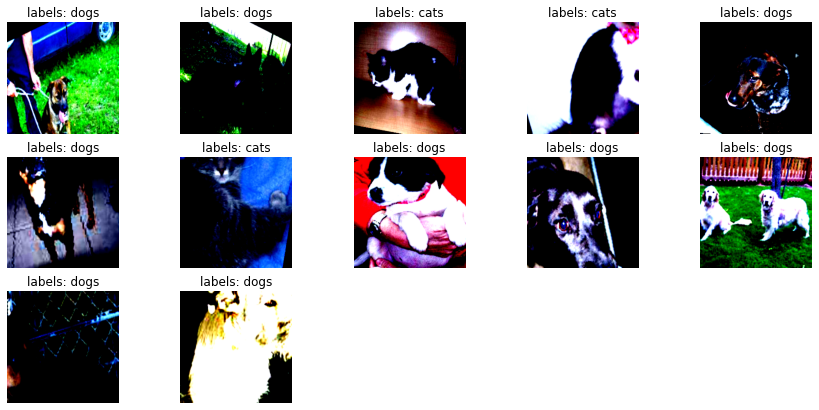

In [ ]:
def image_show(data_loader,n):

  #Read Augmented image data
  tmp = iter(data_loader)
  images,labels = tmp.next()

  #Convert image from tensor to numpy
  images = images.numpy()
  labels = labels.numpy()

  #Take out n images one by one and display them
  fig, ax = plt.subplots(figsize=(15,7))
  for i in range(n):
    plt.subplot(3,5,i+1)
    image = np.transpose(images[i],[1,2,0])
    plt.imshow(image)
    plt.title("labels: " + str(int_to_class[int(labels[i])]))
    plt.axis('off')
  plt.show()

image_show(train_data_loader,12)

In [ ]:
def accuracy(preds,trues):
  preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
  acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
  acc = np.sum(acc) / len(preds)
  return (acc * 100)

In [ ]:
def train_one_epoch(train_data_loader,model,optimizer):
  epoch_loss = []
  epoch_acc = []
  start_time = time.time()
  model.train()

  for images, labels in train_data_loader:
    images = images.to(device)
    labels = labels.to(device)

    labels = labels.reshape((labels.shape[0],1))

    optimizer.zero_grad()

    preds = model(images)

    _loss = criterion(preds,labels)
    loss = _loss.item()
    epoch_loss.append(loss)

    acc = accuracy(preds,labels)
    epoch_acc.append(acc)

    _loss.backward()
    optimizer.step()


  end_time = time.time()
  total_time = end_time - start_time

  epoch_loss = np.mean(epoch_loss)
  epoch_acc = np.mean(epoch_acc)


  train_logs["loss"].append(epoch_loss)
  train_logs["accuracy"].append(epoch_acc)
  train_logs["time"].append(total_time)

  return epoch_loss,epoch_acc,total_time

In [ ]:
def val_one_epoch(val_data_loader, model,best_val_acc,model_name):
  epoch_loss = []
  epoch_acc = []
  start_time = time.time()
  model.eval()


  for images,labels in val_data_loader:

    images = images.to(device)
    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0],1))

    preds = model(images)

    _loss = criterion(preds,labels)
    loss = _loss.item()
    epoch_loss.append(loss)

    acc = accuracy(preds,labels)
    epoch_acc.append(acc)


  end_time = time.time()
  total_time = end_time - start_time

  epoch_loss = np.mean(epoch_loss)
  epoch_acc = np.mean(epoch_acc)

  val_logs["loss"].append(epoch_loss)
  val_logs["accuracy"].append(epoch_acc)
  val_logs["time"].append(total_time)



  if epoch_acc > best_val_acc:
    best_val_acc = epoch_acc
    torch.save(model.state_dict(),model_name + "_best.pth")


  return epoch_loss,epoch_acc,total_time,best_val_acc

###Warm-up

In [ ]:
from torchvision.models import resnet50
model = resnet50(pretrained = True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
for param in model.parameters():
            param.requires_grad = False

In [ ]:
for param in model.parameters():
  print(param.name)

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.0.conv3.weight
layer1.0.bn3.weight
layer1.0.bn3.bias
layer1.0.downsample.0.weight
layer1.0.downsample.1.weight
layer1.0.downsample.1.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer1.1.conv3.weight
layer1.1.bn3.weight
layer1.1.bn3.bias
layer1.2.conv1.weight
layer1.2.bn1.weight
layer1.2.bn1.bias
layer1.2.conv2.weight
layer1.2.bn2.weight
layer1.2.bn2.bias
layer1.2.conv3.weight
layer1.2.bn3.weight
layer1.2.bn3.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.conv3.weight
layer2.0.bn3.weight
layer2.0.bn3.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.we

In [ ]:
dir(model)

['T_destination',
 '__annotations__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backward_hooks',
 '_buffers',
 '_call_impl',
 '_forward_hooks',
 '_forward_impl',
 '_forward_pre_hooks',
 '_get_backward_hooks',
 '_get_name',
 '_is_full_backward_hook',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_make_layer',
 '_maybe_warn_non_full_backward_hook',
 '_modules',
 '_named_members',
 '_non_persistent_buffers_set',
 '_norm_layer',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_replicate_for_data_parallel',
 '_save_to_state_dict',
 '_slow_forward',
 '_state_d

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

lr_sheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 5, gamma = 0.5)

criterion = nn.BCELoss()

In [ ]:
# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 5

In [ ]:
best_val_acc = 0
lrs = []
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader, model, optimizer)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, model, best_val_acc, "resnet50")
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))


    lrs.append(optimizer.param_groups[0]["lr"])
    lr_sheduler.step()


Training
Epoch 1
Loss : 0.2025
Acc : 91.42
Time : 2621.3272

Validating
Epoch 1
Loss : 0.0477
Acc : 98.2628
Time : 620.2979

Training
Epoch 2
Loss : 0.1979
Acc : 92.58
Time : 220.618

Validating
Epoch 2
Loss : 0.0586
Acc : 97.9832
Time : 58.0045

Training
Epoch 3
Loss : 0.158
Acc : 93.74
Time : 218.2633

Validating
Epoch 3
Loss : 0.0662
Acc : 97.6837
Time : 58.1674

Training
Epoch 4
Loss : 0.175
Acc : 93.37
Time : 228.6838

Validating
Epoch 4
Loss : 0.0386
Acc : 98.762
Time : 58.0809

Training
Epoch 5
Loss : 0.1838
Acc : 93.375
Time : 222.8995

Validating
Epoch 5
Loss : 0.041
Acc : 98.6821
Time : 58.4762



##7) Hãy huấn luyện một mô hình small (chẳng hạn MobileNetV3) không sử dụng pretrained model trên 1 epochs.

In [ ]:
from torchvision.models import mobilenet_v3_small
small_model = mobilenet_v3_small(pretrained = False)

In [ ]:
print(small_model)

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [ ]:
small_model.classifier  = nn.Sequential(
    nn.Linear(576, 1, bias = True),
    nn.Sigmoid()
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

lr_sheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size = 5, gamma = 0.5)

criterion = nn.BCELoss()

In [ ]:
# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
small_model.to(device)

# No of epochs 
epochs = 1

In [ ]:
best_val_acc = 0
lrs = []
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader, small_model, optimizer)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, small_model, best_val_acc, "mobinet_v3_small")
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))


    lrs.append(optimizer.param_groups[0]["lr"])
    lr_sheduler.step()


Training
Epoch 1
Loss : 0.6961
Acc : 47.905
Time : 190.6807

Validating
Epoch 1
Loss : 0.6936
Acc : 48.2827
Time : 34.8894


##8) Sử dụng mô hình large làm teacher để cải thiện mô hình small là student theo phương pháp knowledge distillation.

In [ ]:
softmax_op = nn.Softmax()
mseloss_fn = nn.MSELoss()

In [ ]:
anpha = 0.1
betta = 0.9
def my_loss(scores, targets, labels, T=5):
    soft_pred = softmax_op(scores / T)
    soft_targets = softmax_op(targets / T)
    soft_labels = softmax_op(labels/ T)
    loss = anpha* mseloss_fn(soft_pred, soft_targets) + betta * mseloss_fn(soft_pred, soft_labels)
    return loss

In [ ]:
# Hyperparameters
lr = 5e-3
epochs = 3
temp = 5

In [ ]:
# Create optimizer
from torch.optim import Adam
optimizer = Adam(small_model.parameters(), lr=lr)
val_acc = []
train_acc = []
train_loss = [0]  # loss at iteration 0
# Create data loader
batch_size = 32

In [ ]:
def evaluate(model, dataset, max_ex=0):
    acc = 0
    N = len(dataset) * batch_size
    for i, (features, labels) in enumerate(dataset):
      features = features.to(device)
      labels = labels.to(device)
      scores = model(features)
      pred = torch.argmax(scores, dim=1)
      acc += torch.sum(torch.eq(pred, labels)).item()
      if max_ex != 0 and i >= max_ex:
          break
    # print(i)
    return (acc * 100 / ((i+1) * batch_size) )

In [ ]:
big_model = model ###restnet50, small_model is mobinet_v3_small

for epoch in range(epochs):
    for features, labels in train_data_loader:
      features = features.to(device)
      labels = labels.to(device)

      targets = big_model(features)
      scores = small_model(features)
      loss = my_loss(scores, targets, labels, T = temp)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    train_accu_one_epoch = evaluate(small_model, train_data_loader, max_ex=100)
    val_accu_one_epoch = evaluate(small_model, val_data_loader)

    print(f"Epoch {epoch+1}, Train accu = {train_accu_one_epoch}, Val_accu = {val_accu_one_epoch}")

    train_acc.append(train_accu_one_epoch)
    val_acc.append(val_accu_one_epoch)


        # Book-keeping
        # if it % 100 == 0:
        #     train_acc.append(evaluate(small_model, train_data_loader, max_ex=100))
        #     val_acc.append(evaluate(small_model, val_data_loader))
        # it += 1
#perform last book-keeping
# train_acc.append(evaluate(small_model, train_data_loader, max_ex=100))
# val_acc.append(evaluate(small_model, val_data_loader))
# plot_acc(train_acc, val_acc, it, it_per_epoch)m9) Áp dụng thêm các kĩ thuật data augmentation kết hợp ảnh khác nhãn để tạo thành nhãn mềm và huấn luyện cải thiện tiếp model student.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train accu = 51.051980198019805, Val_accu = 24.840255591054312
Epoch 2, Train accu = 50.556930693069305, Val_accu = 24.840255591054312
Epoch 3, Train accu = 49.288366336633665, Val_accu = 24.840255591054312


##9) Áp dụng thêm các kĩ thuật data augmentation kết hợp ảnh khác nhãn để tạo thành nhãn mềm và huấn luyện cải thiện tiếp model student. 

Mix up, Cutout, CutMix

###Cutout

In [ ]:
class Cutout(object):
  def __init__(self, n_holes, length):
      self.n_holes = n_holes
      self.length = length
  def __call__(self,img):
    h = img.size(1)
    w = img.size(2)

    mask = np.ones((h,w), np.float32)

    for n in range(self.n_holes):

      y = np.random.randint(h)
      x = np.random.randint(w)

      y1 = np.clip(y - self.length // 2, 0, h)
      y2 = np.clip(y + self.length // 2, 0, h)
      x1 = np.clip(x - self.length // 2, 0, w)
      x2 = np.clip(x + self.length // 2, 0, w)

      mask[y1: y2, x1: x2] = 0.

      mask = torch.from_numpy(mask)

      mask = mask.expand_as(img)

      img = img * mask

      return img

###Mixup

In [ ]:
def mixup_data(x, y, alpha=1.0, use_cuda=True):
  '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda
      - https://github.com/hongyi-zhang/mixup
  '''
  if alpha > 0.:
    lam = np.random.beta(alpha, alpha)
  else:
    lam = 1.
  batch_size = x.size()[0]
  if use_cuda:
    index = torch.randperm(batch_size).cuda()
  else:
    index = torch.randperm(batch_size)

  mixed_x = lam * x + (1 - lam) * x[index, :]
  y_a, y_b = y, y[index]

  return mixed_x, y_a, y_b, lam

###Cutmix

In [ ]:
def cutmix(batch, alpha):
    data, targets = batch

    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    targets = (targets, shuffled_targets, lam)

    return data, targets

##10) Giả định cần huấn luyện tiếp mô hình student với các dữ liệu mới chưa được gán nhãn. Hãy xây dựng một kĩ thuật lựa chọn mẫu dựa trên đánh giá uncertainty.

In [ ]:
###Active learning